# Data Mining on Titanic.csv




Titanic.csv is provided with the following data legends:

* <strong>PassengerId</strong>:         Index of each passenger record

* <strong>Survived</strong>:            0 means No (died) and 1 means Yes

* <strong>Pclass</strong>:              cabin class, where 1st class is more expensive.

* <strong>Name</strong>:                passenger full name

* <strong>Sex</strong>:                 passenger gender, either male or female

* <strong>Age</strong>:                 passenger age

* <strong>SibSp</strong>:               indicates whether a sibling was present. 0 mean No and 1 means Yes

* <strong>Parch</strong>:               indicates the passenger has a parent or child present. 0 means No and 1 means Yes

* <strong>Ticket</strong>:              ticket reference

* <strong>Fare</strong>:                ticket cost

* <strong>Cabin</strong>:               passenger cabin. For example, C85 indicates cabin #85 is located on deck level C

* <strong>Embarked</strong>:            City where passenger embarked


There are some remarks about the code and the approach selected to answer the questions which are listed here:

* The programming language is Python 2.7

* All the packages used including Pandas, sklearn and pydot are free and accessible for everyone

* In the feature importance analysis missing data are dropped since no info is provided on how to handle missing data

* Most of the questions are about grouping dicing and slicing data which are done with Pandas

* In case of bigger dataset I would use Apache Spark on a Cluster but for this relatively small dataset Python with Pandas takes care of the job

* Important features on passenger's survival are analyzed by using Decision Trees (entropy criterion). Age is the most important factor among the features considered in a passenger's survival. 

* Deck level info is extracted by applying a Regex on Cabin column which matches the format provided. Missing data or wrong format is not considered in the analysis


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image  
from sklearn.externals.six import StringIO
import pydot
%matplotlib inline
plt.style.use('ggplot')

data = pd.read_csv(r'DataSets\titanic.csv')


In [2]:
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<strong>Question: </strong>
<font color='brown'>1.	Who were the passengers on titanic?     
    </font>


In [3]:
data.Name


0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

<strong>Question: </strong>
<font color='brown'>How many males/females on 1st, 2nd & 3rd class?</font>

In [4]:
data[['Pclass', 'Sex', 'PassengerId']].groupby(['Pclass', 'Sex']).agg({'PassengerId':[np.size]})


PassengerId
                     size
Pclass Sex               
1      female          94
       male           122
2      female          76
       male           108
3      female         144
       male           347

<strong>Question: </strong>
<font color='brown'>b.	Assuming a passenger 16 years and younger is considered a child, how many males/females/child on 1st, 2nd and 3rd class?</font>

In [5]:
data['Child'] = data.Age.dropna().apply(lambda x: 0 if x > 16 else 1 )
children = data.loc[data.Child == 1]
children.groupby(['Pclass', 'Sex']).agg({'Child':[np.size]})



Child
               size
Pclass Sex         
1      female   6.0
       male     3.0
2      female  10.0
       male    11.0
3      female  33.0
       male    37.0

<strong>Question: </strong>
<font color='brown'>2.	What deck were passengers on and how does that relate to their class? How many passengers on each deck? Remember the deck level is the letter in front of the cabin number</font>


In [6]:
Cabin_Class = data[['Pclass', 'Cabin', 'PassengerId']].dropna()
Cabin_Class.Cabin = Cabin_Class['Cabin']\
.apply(lambda x: re.findall(r'([A-Z])\d{1,3}', x)[0] if re.findall(r'[A-Z]\d{1,3}', x) else np.NaN)
Cabin_Class.columns = ['Pclass', 'Deck', 'PassengerCount']
Cabin_Class = Cabin_Class.groupby(['Deck', 'Pclass']).count()
Cabin_Class

PassengerCount
Deck Pclass                
A    1                   15
B    1                   47
C    1                   59
D    1                   29
     2                    1
E    1                   25
     2                    4
     3                    4
F    2                    8
     3                    1
G    3                    7

High class prople are mainly on decks A, B, C. Looks like A is highest class and G is all poor people. 

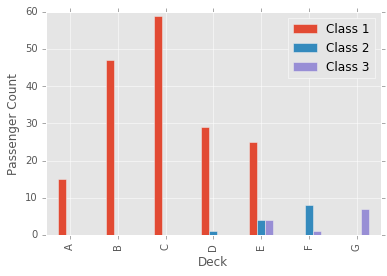

In [7]:
Cabin_Class = Cabin_Class.unstack(level=-1, fill_value=0)
fig = Cabin_Class.plot.bar()
fig.set_ylabel('Passenger Count')
fig.legend(['Class 1', 'Class 2', 'Class 3'])

<strong>Question: </strong><font color='brown'>    b.	How many male/female/child on each deck?</font>

In [8]:
Cabin_Sex = data[['Sex', 'Cabin', 'PassengerId']].dropna()
Cabin_Sex.Cabin = Cabin_Sex['Cabin']\
.apply(lambda x: re.findall(r'([A-Z])\d{1,3}', x)[0] if re.findall(r'[A-Z]\d{1,3}', x) else np.NaN)
Cabin_Sex.columns = ['Sex', 'Deck', 'PassengerCount']
Cabin_Sex = Cabin_Sex.groupby(['Deck', 'Sex']).count()
Cabin_Sex

PassengerCount
Deck Sex                   
A    female               1
     male                14
B    female              27
     male                20
C    female              27
     male                32
D    female              16
     male                14
E    female              16
     male                17
F    female               4
     male                 5
G    female               4
     male                 3

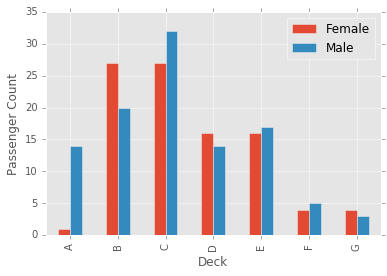

In [9]:
Cabin_Sex_plot = Cabin_Sex.unstack(level=-1, fill_value=0)
fig = Cabin_Sex_plot.plot.bar()
fig.set_ylabel('Passenger Count')
fig.legend(['Female', 'Male'])

In [10]:
children = data.loc[data['Child'] == 1].dropna()
children['Cabin'] = children['Cabin'].apply(lambda x: re.findall(r'([A-Z])\d{1,3}', x)[0] \
                                           if re.findall(r'[A-Z]\d{1,3}', x) else np.NaN)
children.groupby('Cabin')['Child'].count()

Cabin
A    1
B    5
C    2
D    1
E    1
F    4
G    2
Name: Child, dtype: int64

<strong>Question: </strong><font color='brown'>What factors helped a passenger survive the sinking? Infer based on the male/female/child, class, age and cabin.  Explain based on the coefficients of your model.</font>

In [11]:
training_data = data[['Sex', 'Pclass', 'Age', 'Child', 'Cabin', 'Survived']].dropna()
training_data.Cabin = training_data['Cabin'].apply(lambda x: re.findall(r'([A-Z])\d{1,3}', x)[0] \
                                 if re.findall(r'[A-Z]\d{1,3}', x) else np.NaN)

training_data.dropna(inplace=True)
cabin_letters = sorted(training_data['Cabin'].unique().tolist())
Cabins_map = {letter : num for letter, num in zip(cabin_letters, range(len(cabin_letters)))} # {'A':0, 'B':1, ...}
sex_map = {'male':1, 'female':0}
training_data['Sex'] = training_data['Sex'].map(sex_map)
training_data['Cabin'] = training_data['Cabin'].map(Cabins_map)
training_data.head()


,Sex,Pclass,Age,Child,Cabin,Survived
1,0,1,38.0,0.0,2,1
3,0,1,35.0,0.0,2,1
6,1,1,54.0,0.0,4,0
10,0,3,4.0,1.0,6,1
11,0,1,58.0,0.0,2,1


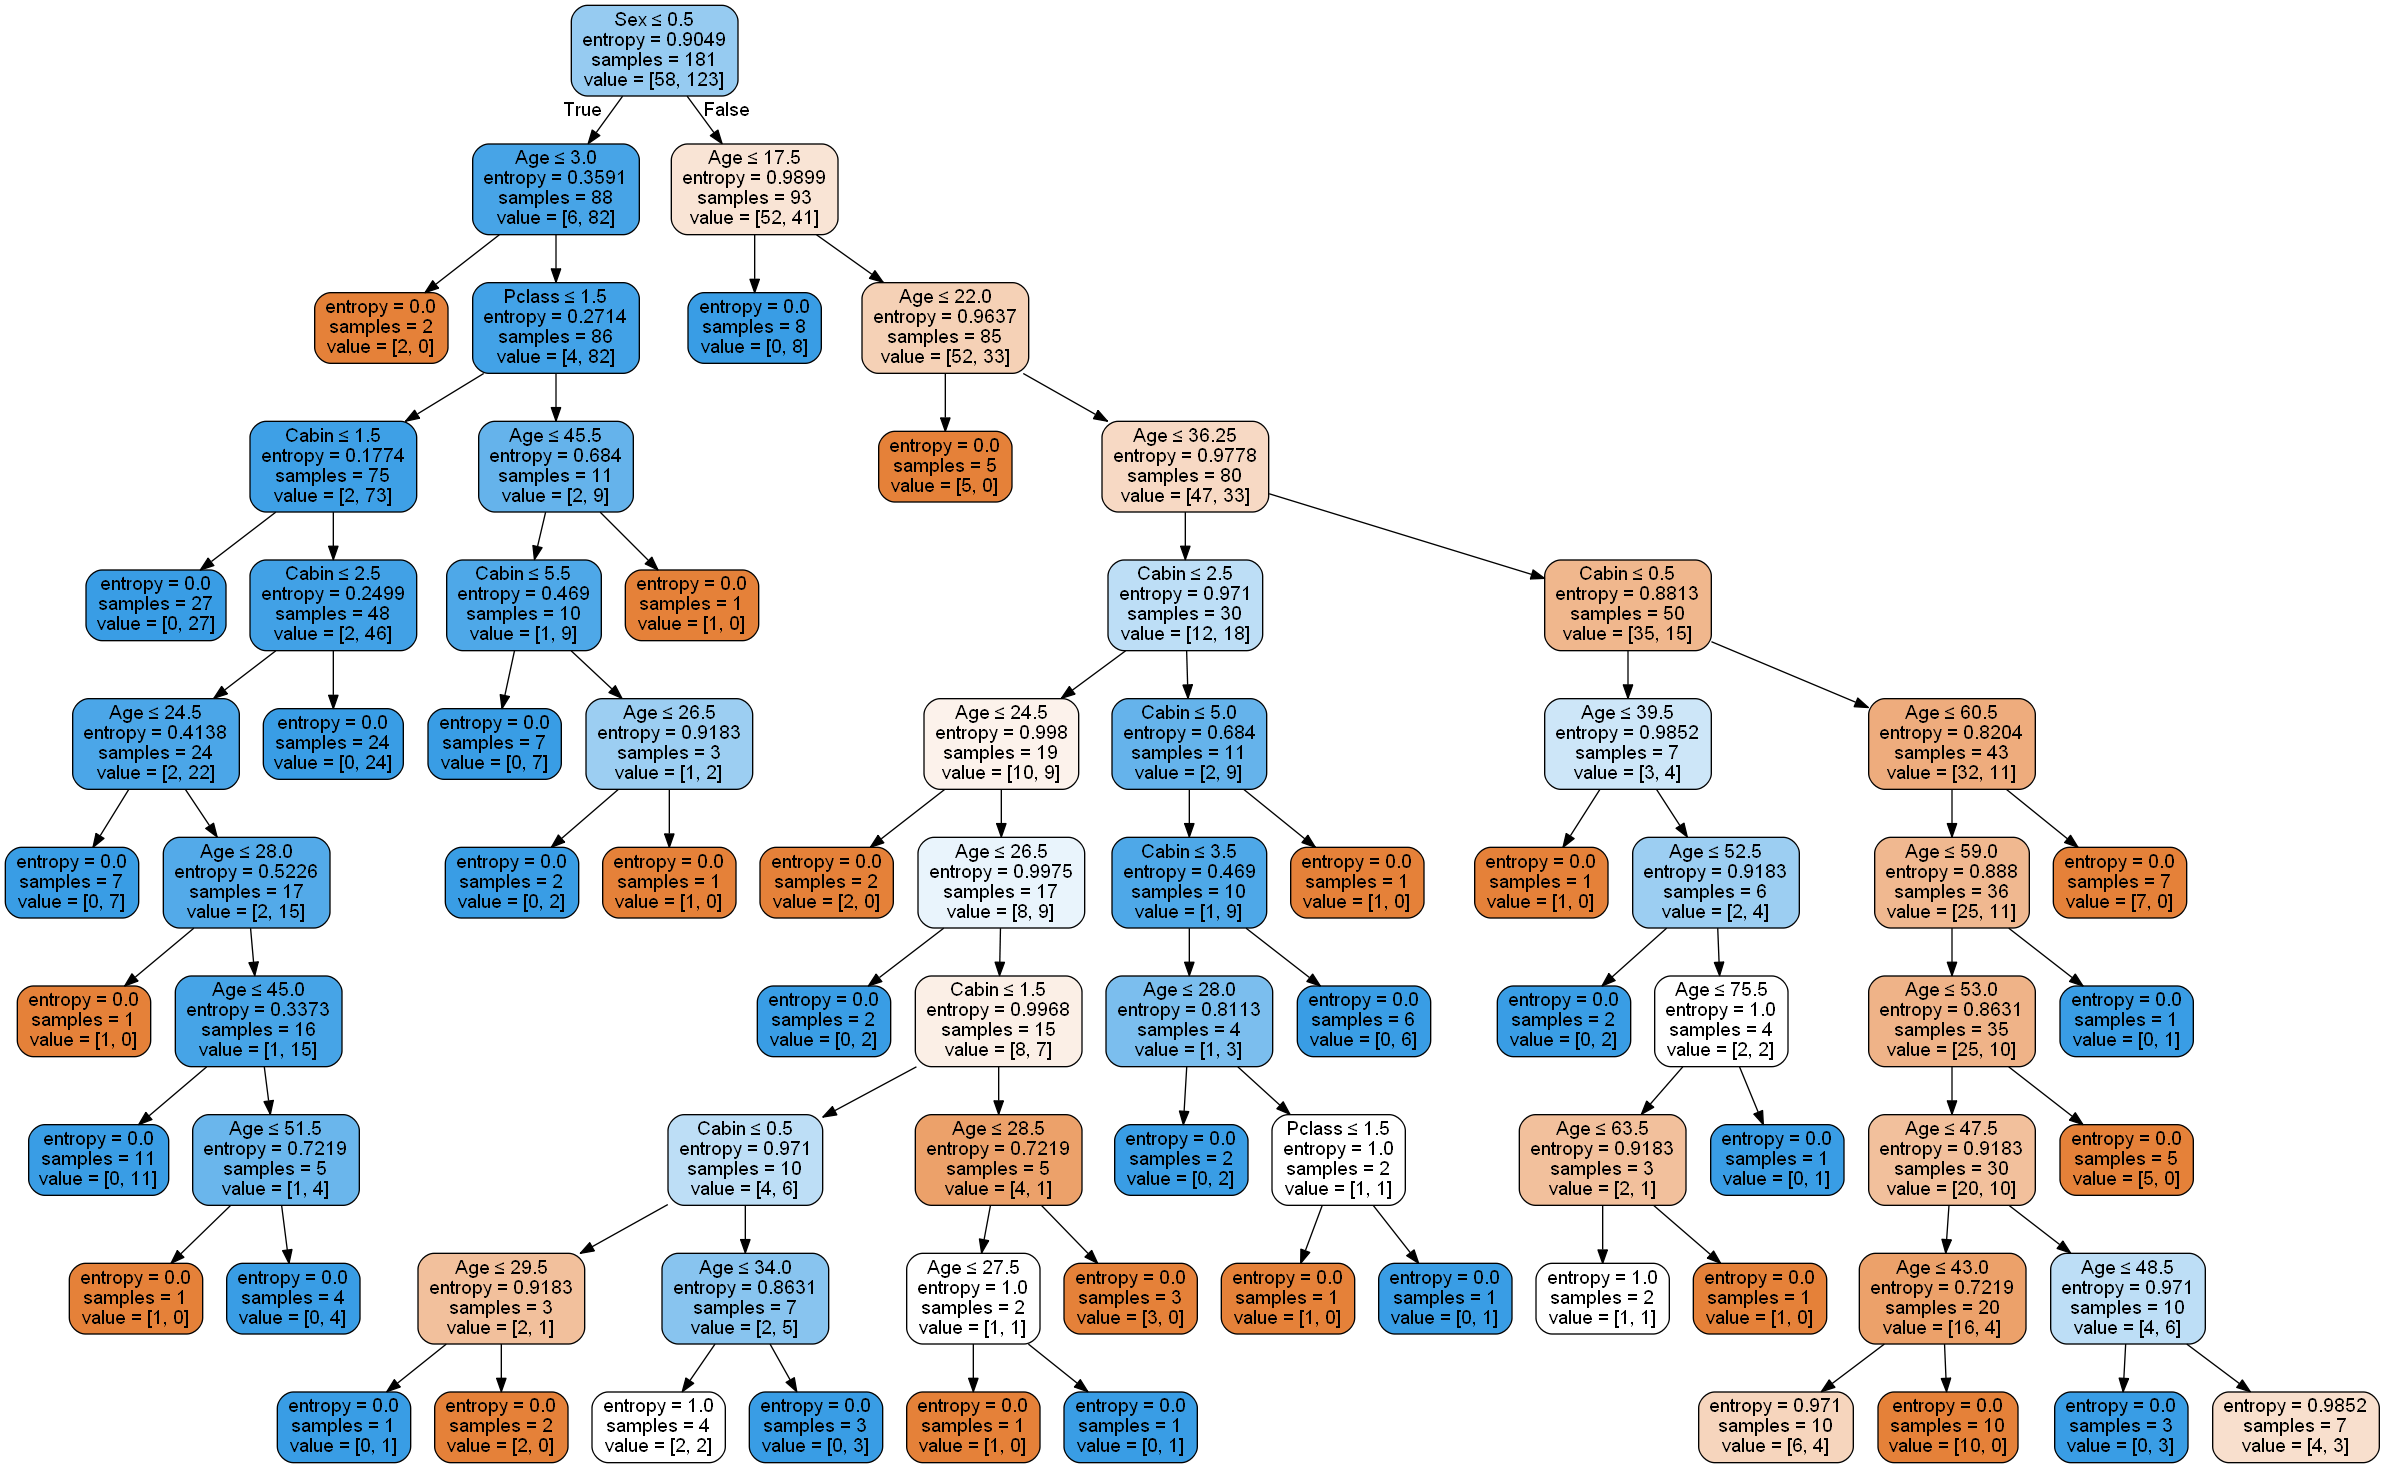

In [12]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)
X = training_data[['Sex', 'Pclass', 'Age', 'Child', 'Cabin']]
y = training_data['Survived']
clf.fit(X, y)
dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data,feature_names=X.columns, filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [13]:
feature_importance = pd.DataFrame(clf.feature_importances_*100, X.columns)
feature_importance.columns = ['% importance in survival']
feature_importance.sort_values(by='% importance in survival', inplace=True, ascending=False)
feature_importance

,% importance in survival
Age,56.580153
Sex,28.418660
Cabin,11.805925
Pclass,3.195262
Child,0.000000
